## Calculate burst-glide statistics and lower-frequency speed changes for each fish in a trial

### Using speed data for each fish:
   - identify time windows without tracking errors/gaps
   - identify burst timing and features (max speed, peak-valley amplitude, rise time, fall time, potentially fit parameters)
   - get sliding burst rate and smoothed speed over time for analyzing speed crosscorrelation in lower frequencies
    

In [1]:
#import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd  # just using this to display things nicely
import get_kinematics_adult as kin

In [2]:
# define directories and import list of lines
datadir = '../data/'
resultdir = 'savedresults/'

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
treatments = np.array(treatments)
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

pxpercm = 4.02361434 * 10  # from tracker

In [52]:
#import single line
tnum = 0  # select which line, 0 = WT
treatment = treatments[tnum]
numtrials = allnumtrials[tnum]
[trial_speeds,trial_trajectories,trial_headings,trial_theta,
            trial_smoothspeeds,trial_smoothtrajectories,trial_smoothheadings,
            trial_ellipses,trial_arena,trial_sex,
            datafiles,trial_trackingerrors] = pickle.load(open(datadir+treatment+'-alltrials.pkl','rb'))

In [51]:
#load fishpair distances from file
filename = datadir+treatment+'-dcoords+dist-heading.pkl'
[trial_dcoords,trial_dist] = pickle.load(open(filename,'rb'))

In [80]:
trial_headings[0]

array([[-1.16317914, -1.9180828 , -1.79156783, -1.06572235, -1.82983046,
        -1.34165018],
       [-1.16939637, -1.88617661, -1.79994801, -1.10705365, -1.83903158,
        -1.3358294 ],
       [-1.16814989, -1.807371  , -1.66897862, -1.18188492, -1.8484831 ,
        -1.32891067],
       ...,
       [-0.11442442,         nan,  2.41916635,         nan,  2.44419482,
        -0.64016974],
       [-0.12035425,         nan,  2.35126817,         nan,  2.45406425,
        -0.60138212],
       [-0.097265  ,         nan,  2.32842505,         nan,  2.49272354,
        -0.57112364]])

In [22]:
#select single trial for line and fish to include in analysis 
#(later: setup to iterate through all trials & save relevant data)
trialnum = 0
fishIncl = np.arange(6)
nframes = trial_trajectories[trialnum].shape[0]
#x = trial_trajectories[trialnum][:,fishIncl,0]
#y = trial_trajectories[trialnum][:,fishIncl,1]
#errs = trial_trackingerrors[trialnum][:,fishIncl]

## Identify frames with bad data for each fish

In [42]:
#initialize badData dataframe; types: nan, flatspeed, doubleID (note which), other
errType = pd.DataFrame(np.zeros([nframes,fishIncl.size], dtype=int), columns = ['fish0','fish1','fish2','fish3','fish4','fish5'])
errType.index.name = 'frame'
errType.head()
errCode = {0: 'noError',
 1: 'missing',
 2: 'flatSpeed',
 30: 'doubleID_0',
 31: 'doubleID_1',
 32: 'doubleID_2',
 33: 'doubleID_3',
 34: 'doubleID_4',
 35: 'doubleID_5'}

In [91]:
#add nans/missing data to errType
errs = trial_trackingerrors[trialnum][:,fishIncl]
errType[errs] = 1

,fish0,fish1,fish2,fish3,fish4,fish5
frame,,,,,,
100,1,1,0,0,0,0
102,1,1,0,0,0,0
117,1,0,0,0,0,0
118,1,0,0,0,0,0
119,1,0,0,0,0,0
...,...,...,...,...,...,...
107788,1,1,0,0,1,0
107789,1,1,0,1,1,0
107790,1,1,0,1,1,0


In [ ]:
#find flatspeed for each fish - speed does not change (or change < threshold) for >t duration; define as baddata

In [132]:
#define baddata for at least one fish in pair when [dist,oridiff] < threshold (doubleID error)

#for each fishpair, each time point, get distance (trial_dist from file) and orientation diff (subtr heading)
dthresh = pxpercm #1 cm, ~40 pixels; same threshold used in paper; I may use looser threshold
othresh = .2 #taken from paper

for i in fishIncl:
    col0 = errType.columns[i]
    errcode1 = 30 + i
    for j in range(i+1,fishIncl.size):
        col1 = errType.columns[j]
        errcode0 = 30 +j
        dpair = trial_dist[trialnum][:,i,j] #check that index is right
        dpair[np.isnan(dpair)] = 100 #set nans to high values to avoid invalid values and false errID
        oridiff = trial_headings[trialnum][:,i]-trial_headings[trialnum][:,j]
        oridiff[np.isnan(oridiff)] = 6 #set nans to high values to avoid invalid values and false errID
        indErr = (abs(oridiff) < othresh) & (dpair < dthresh)
        errType.loc[indErr,col0] = errcode0
        errType.loc[indErr,col1] = errcode1

1900.768095714322

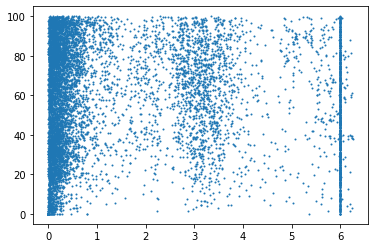

In [141]:
plt.scatter(abs(oridiff[dpair<100]),dpair[dpair<100], s = 1)
np.max(dpair)


In [ ]:
#maybe: interpolate speed and position for nans??

## find bursts in speed trajectory

   - Build on get_kinematics function for getting BGCycle
   - Tweak parameters for burst detection (especially nback)
   - Maybe: try w both smoothed and raw trajectories, see which is better
   - Either only do for good trajectories, or note when burst is baddata